The goal of this notebook is to create a student-teacher model where we first train a teacher on labeled data, and then use this teacher model to label more data, then we swap out the teacher with a student and train again over all the samples. 

# Loading data

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import datetime
import time
import os
import pathlib
import matplotlib.pyplot as plt
 
# Some stuff to make utils-function work
import sys
sys.path.append('../utils')
from pipeline import create_dataset, split_and_create_dataset, prepare_for_training
from utils import show_image, class_distribution
from utils import print_split_info, unpipe, tf_bincount, checkout_dataset
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

project_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

Some parameters

In [2]:
data_dir = pathlib.Path('/home/henriklg/master-thesis/data/hyper-kvasir/labeled_ttv/')
unlab_dir = pathlib.Path('/home/henriklg/master-thesis/data/hyper-kvasir/unlabeled_ttv/')

iteration = 0
model_name = str(iteration)+"_teacher"
log_dir = "./logs/{}/{}".format(project_time, model_name)

conf = {
    # Dataset
    "data_dir": data_dir,
    "unlab_dir": unlab_dir,
    "log_dir": log_dir,
    "cache_dir": "./cache",
    "ds_info": 'hypkva',
    "augment": ["crop","flip","brightness","saturation","contrast","rotate"],
    "aug_mult": 0.5,
    "resample": True,
    "class_weight": False,
    "shuffle_buffer_size": 2000,        # 0=no shuffling
    "seed": 2511,
    "neg_class": None,                 # select neg class for binary ds (normal class)
    "outcast": None,                   # list of folders to drop - currently only works for 1 item
    # Model
    "model_name": model_name,
    "model": 'EfficientNetB2',
    "weights": "imagenet",             # which weights to initialize the model with
    "dropout": 0.2,
    "num_epochs": 3,
    "batch_size": 16,
    "img_shape": (128, 128, 3),
    "learning_rate": 0.001,
    "optimizer": 'Adam',
    "final_activation": 'softmax',     # sigmoid for binary ds
    # Callbacks
    "learning_schedule": False,
    "decay_rate": 16.0,                 # 128:0.25   64:1.0   32:4.0   16:16   8:64
    "checkpoint": False,
    "early_stopp": True,
    "early_stopp_patience": 7,
    # Misc
    "verbosity": 1,
    "keep_threshold": 0.90
    }

Create training, testing and validation dataset from utils/data_prep.py.  
Returns tf.dataset for shuffled, cached and batched data

In [3]:
ds = create_dataset(conf)

class_names = conf["class_names"]

Dataset split: {'train': 7454, 'test': 1598, 'val': 1610, 'total': 10662} 

Category                    : train | test  | val   | total | % of total 
------------------------------------------------------------------------
barretts-short-segment      :    37 |     8 |     8 |    53 |  0.50%
retroflex-stomach           :   534 |   115 |   115 |   764 |  7.17%
ulcerative-colitis-0-1      :    24 |     5 |     6 |    35 |  0.33%
ulcerative-colitis-grade-3  :    93 |    20 |    20 |   133 |  1.25%
esophagitis-b-d             :   182 |    39 |    39 |   260 |  2.44%
dyed-resection-margins      :   692 |   148 |   149 |   989 |  9.28%
hemorrhoids                 :     4 |     1 |     1 |     6 |  0.06%
normal-z-line               :   652 |   140 |   140 |   932 |  8.74%
esophagitis-a               :   282 |    60 |    61 |   403 |  3.78%
ulcerative-colitis-1-2      :     7 |     2 |     2 |    11 |  0.10%
barretts                    :    28 |     6 |     7 |    41 |  0.38%
bbps-2-3          

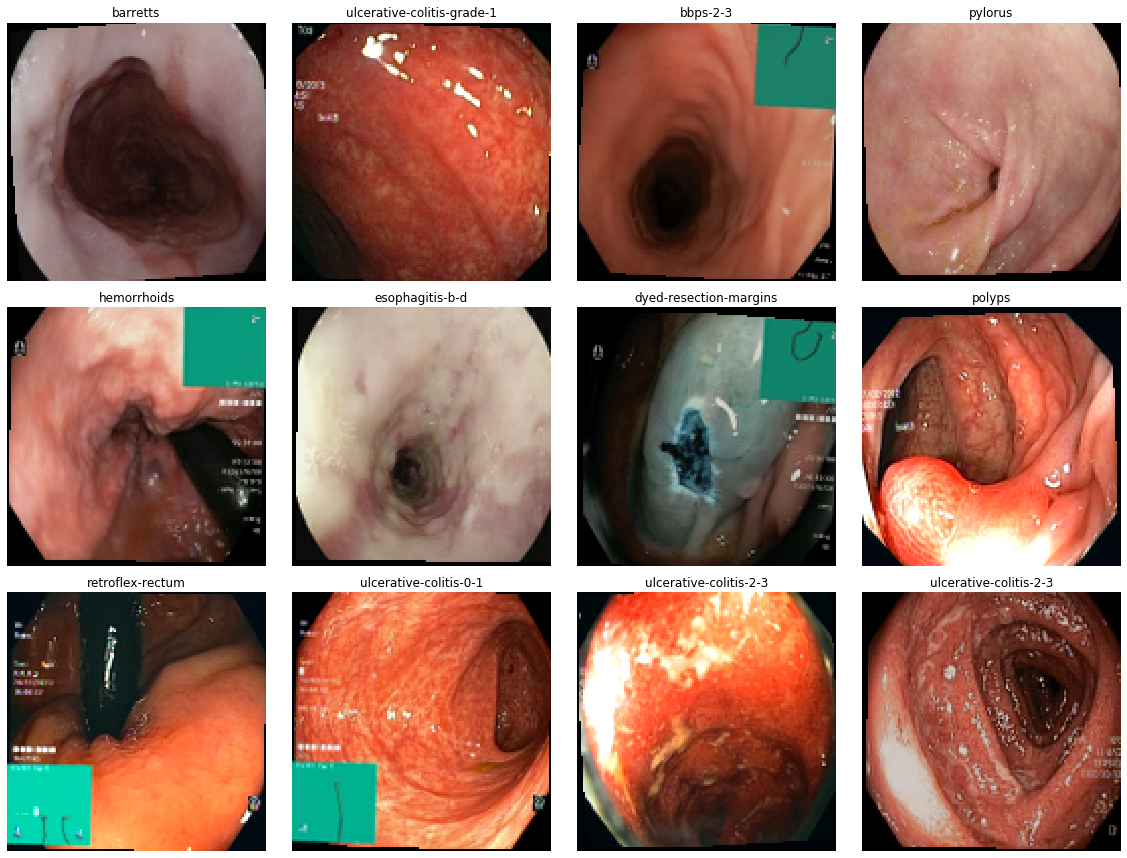

In [4]:
# Show some images from training dataset - mainly to verify augmentation and distribution
# add params for title and log_dir for savefig
checkout_dataset(ds["train"], conf)

# Step 1: Train a teacher model on labeled images

In [5]:
from tensorflow.python.keras.models import Model, load_model
from create_model import create_model
from create_model import create_callbacks
from utils import write_to_file
from utils import get_class_weights

teacher_model = create_model(conf)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b2 (Model)      (None, 4, 4, 1408)        7768562   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               721408    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 23)                11799     
Total params: 8,501,769
Trainable params: 8,434,201
Non-trainable params: 67,568
_________________________________________

### Callbacks

In [6]:
callbacks = create_callbacks(conf)

#### Class weight

In [7]:
class_weights = get_class_weights(ds["train"], conf)

### Train the teacher model

In [8]:
write_to_file(conf, conf, "conf") #ignore stupid arguments
start_time = time.time()

teacher_history = teacher_model.fit(
        ds["train"],
        steps_per_epoch = conf["steps"]["train"],
        epochs = conf["num_epochs"],
        validation_data = ds["test"],
        validation_steps = conf["steps"]["test"],
        validation_freq = 1,
        class_weight = class_weights,
        callbacks = callbacks,
        verbose = 1
)
print ("Time spent on training: {} minutes.".format(np.round(time.time() - start_time)/60))

# Save the metrics from training
write_to_file(teacher_history.history, conf, "teacher_history")

Train for 465 steps, validate for 99 steps
Epoch 1/3
465/465 [==============================] - 45s 97ms/step - loss: 1.1848 - sparse_categorical_accuracy: 0.6035 - val_loss: 0.8496 - val_sparse_categorical_accuracy: 0.7424
Epoch 2/3
465/465 [==============================] - 33s 72ms/step - loss: 0.7037 - sparse_categorical_accuracy: 0.7550 - val_loss: 0.6240 - val_sparse_categorical_accuracy: 0.7980
Epoch 3/3
465/465 [==============================] - 32s 69ms/step - loss: 0.5539 - sparse_categorical_accuracy: 0.8050 - val_loss: 0.6835 - val_sparse_categorical_accuracy: 0.8030
Time spent on training: 1.85 minutes.


### Save or restore a model

In [ ]:
teacher_model.save(conf["log_dir"]+'/model')
# teacher_model = tf.keras.models.load_model("./logs/20200526-121128/teacher1/model")

## Evaluate the model

In [9]:
from model_evaluation import get_classification_report
from model_evaluation import get_metrics, get_confusion_matrix
from model_evaluation import show_dataset_predictions
from model_evaluation import plot_confusion_matrix, plot_lr_and_accuracy

100/100 - 2s - loss: 0.5983 - sparse_categorical_accuracy: 0.8213


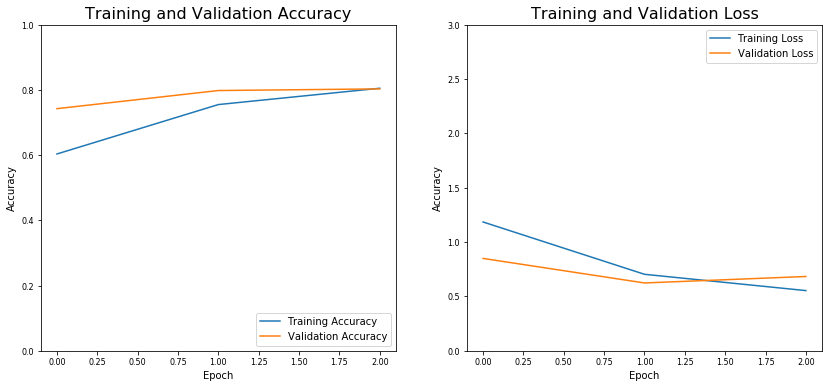

1610/1610 [==============================] - 1s 761us/sample
                            precision    recall  f1-score   support

    barretts-short-segment      0.154     0.500     0.235         8
         retroflex-stomach      0.961     0.861     0.908       115
    ulcerative-colitis-0-1      0.286     0.333     0.308         6
ulcerative-colitis-grade-3      0.464     0.650     0.542        20
           esophagitis-b-d      1.000     0.154     0.267        39
    dyed-resection-margins      0.903     0.812     0.855       149
               hemorrhoids      0.000     0.000     0.000         1
             normal-z-line      0.809     0.786     0.797       140
             esophagitis-a      0.382     0.475     0.423        61
    ulcerative-colitis-1-2      0.000     0.000     0.000         2
                  barretts      0.364     0.571     0.444         7
                  bbps-2-3      0.987     0.873     0.926       173
                     ileum      0.000     0.000     0.

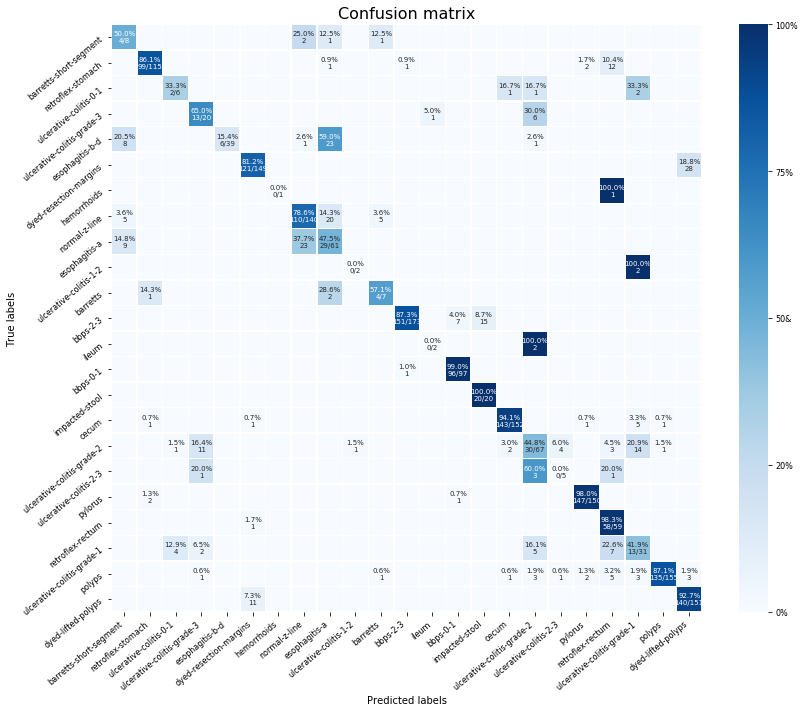

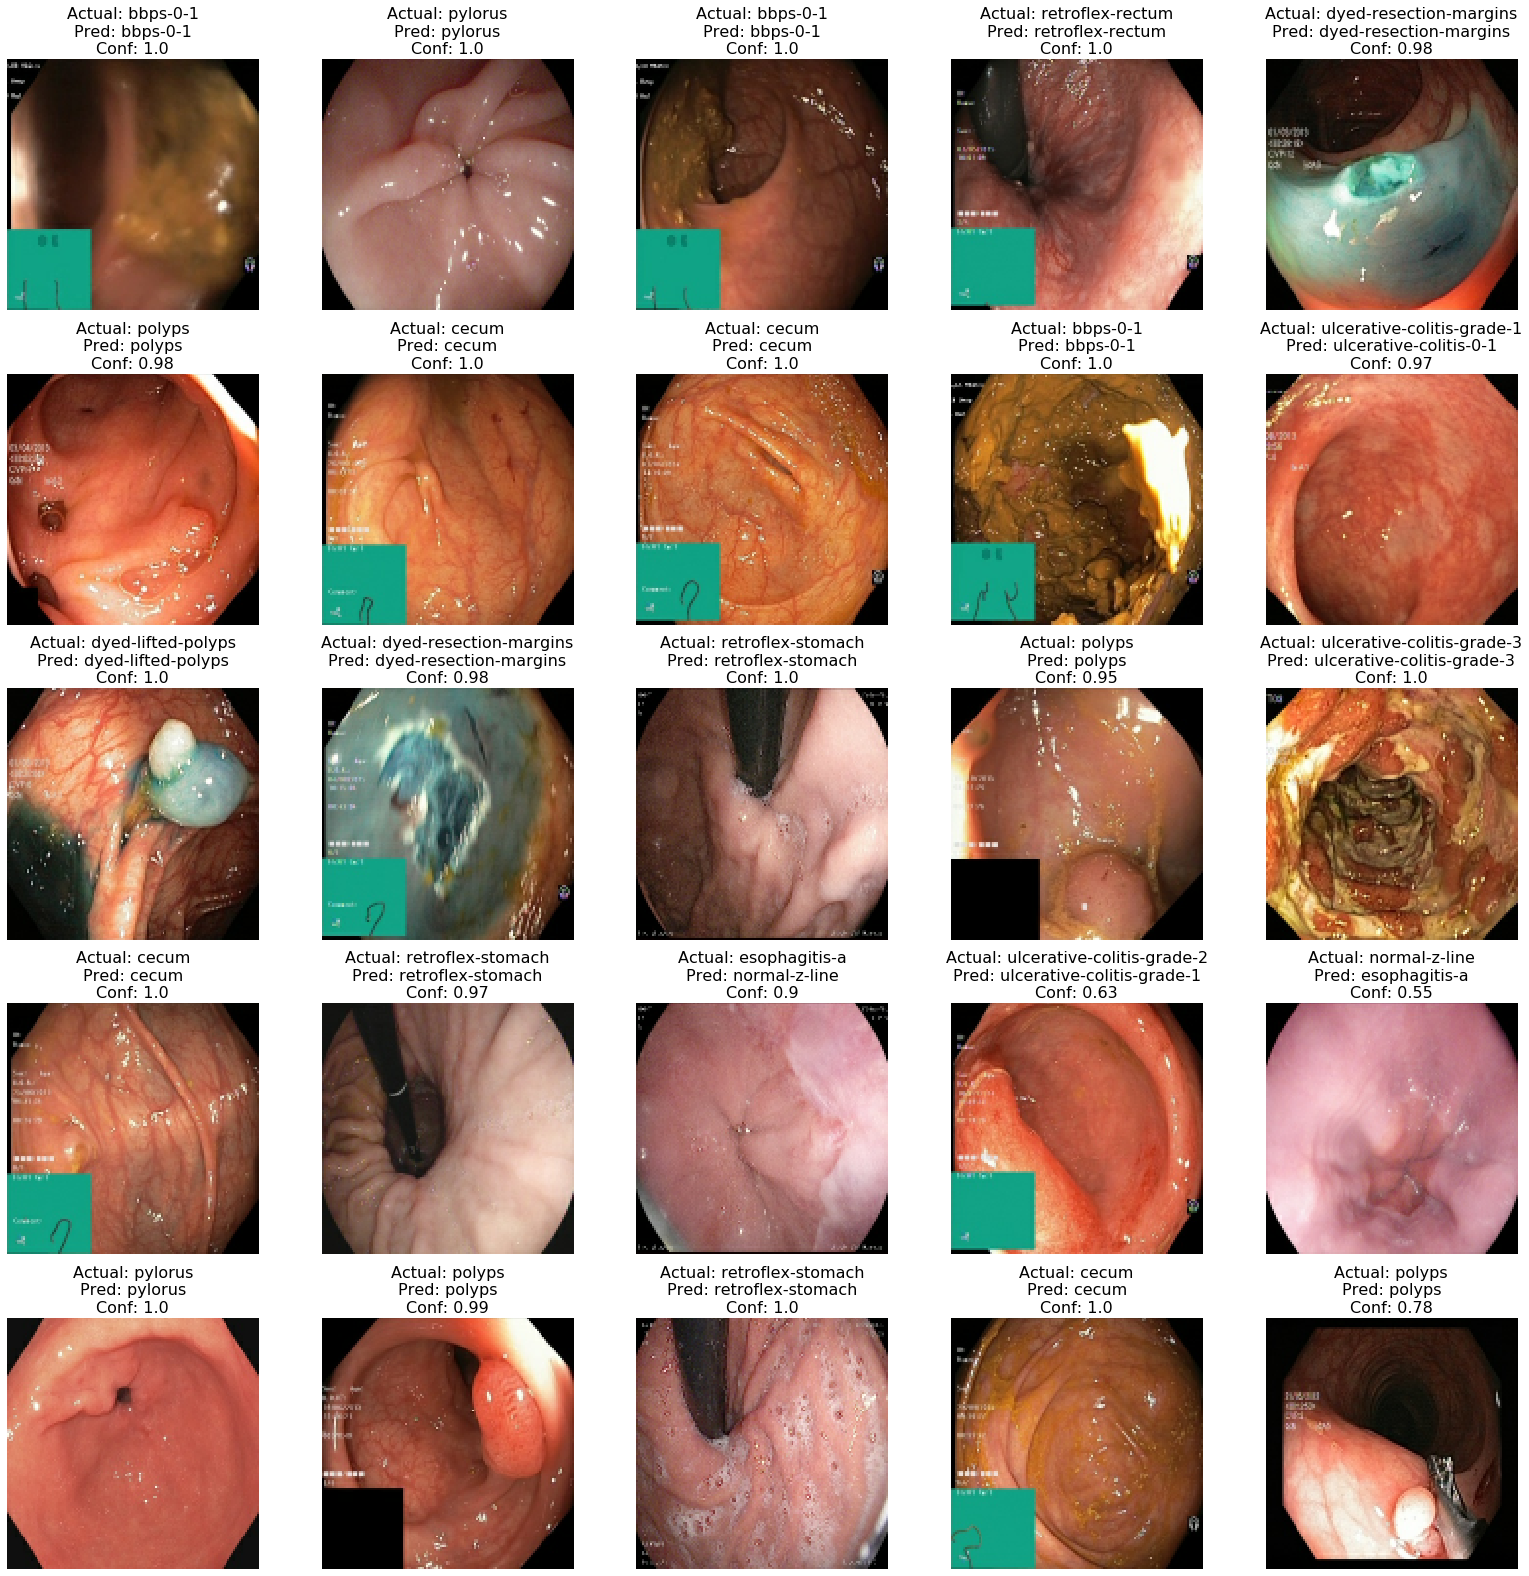

In [16]:
# tf.Keras model evaluation and learning rate
teacher_evaluate = teacher_model.evaluate(ds["val"], verbose=2, steps=conf["steps"]["val"])
write_to_file(teacher_evaluate, conf, "evaluate_val")

# Plot leanring rate and loss
plot_lr_and_accuracy(teacher_history, conf)

# Create true_labels and pred_labels for later evaluations
eval_ds = unpipe(ds["val"], conf["ds_sizes"]["val"]).as_numpy_iterator()
eval_ds = np.array(list(eval_ds))
eval_images = np.stack(eval_ds[:,0], axis=0)
predictions = teacher_model.predict(eval_images, verbose=1)
pred_confidence = [np.max(pred) for pred in predictions]
true_labels = list(eval_ds[:,1])
pred_labels = [np.argmax(pred) for pred in predictions]

# Classification report
report = get_classification_report(
        true_labels, 
        pred_labels, 
        range(conf["num_classes"]), 
        target_names=conf["class_names"]
)
print (report)
write_to_file(report, conf, "classification_report")

# Confusion matrix
cm = get_confusion_matrix(true_labels, pred_labels)
plot_confusion_matrix(cm, log_dir, conf["class_names"], figsize=(12,10))

# some some sample predictions from evaluation data
show_dataset_predictions(
        true_labels,
        pred_labels,
        pred_confidence,
        eval_images,
        conf,
)

# Step 2: use the teacher to generate pseudo labels on unlabeled images

### Read in the unlabeled dataset

In [ ]:
from pipeline import create_unlab_ds

from utils import print_bar_chart
from utils import checkout_findings
from utils import checkout_class

from unlabeled_utils import custom_sort
from unlabeled_utils import resample_unlab
from unlabeled_utils import generate_labels
from unlabeled_utils import reduce_dataset

unlab_ds, unlab_size = create_unlab_ds(conf)

### Run predictions on all unlabeled images

In [ ]:
count = {"findings": 0, "total": 0}

unlab_findings = {
    "pred_list": [],
    "lab_list": [],
    "name_list": []
}

In [ ]:
unlab_findings, count = generate_labels(
    count, unlab_findings, unlab_ds, unlab_size, teacher_model, conf)

In [ ]:
import pickle

# Dump it as a pickle
with open(conf["log_dir"]+"/unlab_findings.pkl", 'wb') as f:
    pickle.dump(unlab_findings, f)

# Load a pickle
# pickle_path = "/home/henriklg/master-thesis/code/hyper-kvasir/logs/20200526-121128/teacher1/"
# new_unlab = pickle.load (open (pickle_path+"/unlab_findings.pkl", "rb"))

## Inspect the classified images

In [ ]:
# Sort in order of highest confidence to lowest
unlab_findings = custom_sort(unlab_findings)

checkout_findings(unlab_findings, conf)

In [ ]:
# Print grid of images from one of the classes
checkout_class("polyps", unlab_findings, conf)

### Resample new findings, convert to tf.tensors and concatenate with original training data, and update unlab_ds

In [ ]:
# Count original dataset
datasets_bin = []
datasets_bin.append(tf_bincount(ds["clean_train"], conf["num_classes"]))

# Resample and convert to tf.tensors
if conf["resample"]:
    new_findings, added_samples = resample_unlab(unlab_findings, datasets_bin[-1], conf)
    # create tf.tensor of the new findings
    findings_tensor = tf.data.Dataset.from_tensor_slices(new_findings)
else:
    added_samples = len(unlab["name_list"])
    img_list = [fn2img(name, conf["unlab_ds"], conf["img_shape"][0]) for name in unlab["name_list"]]
    findings_tensor = tf.data.Dataset.from_tensor_slices([img_list, unlab["lab_list"]])
    
# combine with original training_ds (using clean_ds which is not augmented/repeated etc)
if len(added_samples) != 0: # if no samples are added just reuse previous combined_train
    ds["combined_train"] = ds["clean_train"].concatenate(findings_tensor)

# count samples in the new/combined dataset
datasets_bin.append(tf_bincount(ds["combined_train"], conf["num_classes"]))

# History of class distribution
from utils import print_bar_chart
print_bar_chart(
    data=datasets_bin,
    conf=conf,
    title=None,
    fname="bar_chart-distribution"
)

# Update unlab_ds
unlab_ds = reduce_dataset(unlab_ds, remove=added_samples)
prev_unlab_size = unlab_size
unlab_size = unlab_size - len(added_samples)

### Sanity check

In [ ]:
sanity = [{"added_samples": len(added_samples),
           "last_unlab_size": prev_unlab_size,
           "curr_unlab_size": unlab_size,
           "last_train_size": int(np.sum(datasets_bin[-2])),
           "curr_train_size": int(np.sum(datasets_bin[-1]))
          }]
write_to_file(sanity, conf, "sanity")

sanity

# Step 3: Train a student model on the combination of labeled images and pseudo labeled images

Now we have trained a teacher model, and used that model to predict on unlabeled dataset to create more samples with psudo-labels.  
It's time for swapping the teacher with the student!

In [ ]:
# save teacher conf
teacher_conf = conf

# Make changes
model_name = str(iteration)+"_student"
log_dir = "./logs/{}/{}".format(project_time, model_name)

# Dataset
conf["log_dir"] = log_dir
conf["ds_sizes"]["train"] = sanity[-1]["curr_train_size"]
conf["steps"]["train"] = sanity[-1]["curr_train_size"]//conf["batch_size"] 
conf["aug_mult"] = 0.5
# Model
conf["model_name"] = model_name
# conf["model"] = 'EfficientNetB6'
conf["dropout"] = 0.2
# conf["batch_size"] = 64
# conf["num_epochs"] = 25
# conf["verbosity"] = 1

In [ ]:
ds["train"] = prepare_for_training(
        ds=ds["combined_train"], 
        ds_name='train_'+model_name,
        num_classes=conf["num_classes"],
        conf=conf,
        cache=True
    )

In [ ]:
checkout_dataset(ds["train"], conf)

In [ ]:
# create model, callbacks and weights
student_model = create_model(conf)
callbacks = create_callbacks(conf) 
class_weights = get_class_weights(ds["train"], conf)

In [ ]:
write_to_file(conf, conf, "conf") 
start_time = time.time()

student_history = student_model.fit(
    ds["train"],
    steps_per_epoch = conf["steps"]["train"], 
    epochs = conf["num_epochs"],
    validation_data = ds["test"],
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    class_weight = class_weights,
    callbacks = callbacks
)
print ("Time spent on training: {} minutes.".format(np.round(time.time() - start_time)/60))

# Save the metrics from training
write_to_file(student_history.history, conf, "student_history")

# Save the model
student_model.save(conf["log_dir"]+'/model')

### Evaluate the model

In [ ]:
# tf.Keras model evaluation
student_evaluate = student_model.evaluate(ds["val"], verbose=2, steps=conf["steps"]["val"])
write_to_file(student_evaluate, conf, "evaluate_val")

# Plot leanring rate and loss
plot_lr_and_accuracy(student_history, conf)

# Create true_labels and pred_labels for later evaluations
eval_ds = unpipe(ds["val"], conf["ds_sizes"]["val"]).as_numpy_iterator()
eval_ds = np.array(list(eval_ds))
eval_images = np.stack(eval_ds[:,0], axis=0)
predictions = student_model.predict(eval_images, verbose=1)
pred_confidence = [np.max(pred) for pred in predictions]
true_labels = list(eval_ds[:,1])
pred_labels = [np.argmax(pred) for pred in predictions]


# Classification report
report = get_classification_report(
        true_labels, 
        pred_labels, 
        range(conf["num_classes"]), 
        target_names=conf["class_names"]
)
print (report)
write_to_file(report, conf, "classification_report")

# Confusion matrix
cm = get_confusion_matrix(true_labels, pred_labels)
plot_confusion_matrix(cm, log_dir, conf["class_names"], figsize=(10,8))

# some some sample predictions from evaluation data
show_dataset_predictions(
        true_labels,
        pred_labels,
        pred_confidence,
        eval_images,
        conf,
)

# Step 3.2: use the teacher to generate pseudo labels on unlabeled images

In [ ]:
count = {"findings": 0, "total": 0}

unlab_findings = {
    "pred_list": [],
    "lab_list": [],
    "name_list": []
}

In [ ]:
unlab_findings, count = generate_labels(
    count, unlab_findings, unlab_ds, unlab_size, student_model, conf)

In [ ]:
import pickle

# Dump it as a pickle
with open(conf["log_dir"]+"/unlab_findings.pkl", 'wb') as f:
    pickle.dump(unlab_findings, f)

# Load a pickle
# pickle_path = "/home/henriklg/master-thesis/code/hyper-kvasir/logs/20200526-121128/teacher1/"
# new_unlab = pickle.load (open (pickle_path+"/unlab_findings.pkl", "rb"))

### Inspect the classified images

In [ ]:
# Sort in order of highest confidence to lowest
unlab_findings = custom_sort(unlab_findings)

checkout_findings(unlab_findings, conf)

In [ ]:
# Print grid of images from one of the classes
checkout_class("polyps", unlab_findings, conf)

### Resample new findings, convert to tf.tensors and concatenate with original training data, and update unlab_ds

In [ ]:
# Resample and convert to tf.tensors
if conf["resample"]:
    new_findings, added_samples = resample_unlab(unlab_findings, datasets_bin[-1], conf)
    findings_tensor = tf.data.Dataset.from_tensor_slices(new_findings)
else:
    added_samples = len(unlab["name_list"])
    img_list = [fn2img(name, conf["unlab_ds"], conf["img_shape"][0]) for name in unlab["name_list"]]
    findings_tensor = tf.data.Dataset.from_tensor_slices([img_list, unlab["lab_list"]])

# combine with previous training dataset
if len(added_samples) != 0: # if no samples are added just reuse previous combined_train
    ds["combined_train"] = ds["combined_train"].concatenate(findings_tensor)

# count samples in the new/combined dataset
datasets_bin.append(tf_bincount(ds["combined_train"], conf["num_classes"]))

# Display history of class distribution
print_bar_chart(
    data=datasets_bin,
    conf=conf,
    title=None,
    fname="bar_chart-distribution"
)

# Refresh the unlabeled dataset
unlab_ds = reduce_dataset(unlab_ds, remove=added_samples)
prev_unlab_size = unlab_size
unlab_size = unlab_size - len(added_samples)

### Sanity check

In [ ]:
sanity.append({
    "added_samples": len(added_samples),
    "last_unlab_size": prev_unlab_size,
    "curr_unlab_size": unlab_size,
    "last_train_size": int(np.sum(datasets_bin[-2])),
    "curr_train_size": int(np.sum(datasets_bin[-1]))
})
write_to_file(sanity, conf, "sanity")

sanity

# Step 4: Iterate this algorithm a few times by treating the student as a teacher to relabel the unlabeled data and training a new student

# Second iteration - Part 1
# --- Teacher 2 ---

In [ ]:
# save teacher conf
teacher_conf = conf

# Make changes
iteration += 1
model_name = str(iteration)+"_teacher"
log_dir = "./logs/{}/{}".format(project_time, model_name)

# Dataset
conf["log_dir"] = log_dir
conf["ds_sizes"]["train"] = sanity[1]["curr_train_size"]
conf["aug_mult"] = 0.5
# Model
conf["model_name"] = model_name
# conf["model"] = 'EfficientNetB0'
conf["dropout"] = 0.2
# conf["batch_size"] = 128
# conf["num_epochs"] = 25

In [ ]:
ds["train"] = prepare_for_training(
        ds=ds["combined_train"], 
        ds_name='train_'+model_name,
        num_classes=conf["num_classes"],
        conf=conf,
        cache=True
    )

In [ ]:
checkout_dataset(ds["train"], conf)

In [ ]:
# create model, callbacks and weights
teacher_model = create_model(conf)
callbacks = create_callbacks(conf) 
class_weights = get_class_weights(ds["train"], conf)

In [ ]:
write_to_file(conf, conf, "conf") 
start_time = time.time()

teacher_history = teacher_model.fit(
    ds["train"],
    steps_per_epoch = conf["steps"]["train"], 
    epochs = conf["num_epochs"],
    validation_data = ds["test"],
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    class_weight = class_weights,
    callbacks = callbacks
)
print ("Time spent on training: {} minutes.".format(np.round(time.time() - start_time)/60))

# Save the metrics from training
write_to_file(teacher_history.history, conf, "teacher_history")

# Save the model
student_model.save(conf["log_dir"]+'/model')

## Evaluate the model

In [ ]:
# tf.Keras model evaluation
teacher_evaluate = teacher_model.evaluate(ds["val"], verbose=2, steps=conf["steps"]["val"])
write_to_file(teacher_evaluate, conf, "evaluate_val")

# Plot leanring rate and loss
plot_lr_and_accuracy(teacher_history, conf)

# Create true_labels and pred_labels for later evaluations
eval_ds = unpipe(ds["val"], conf["ds_sizes"]["val"]).as_numpy_iterator()
eval_ds = np.array(list(eval_ds))
eval_images = np.stack(eval_ds[:,0], axis=0)
predictions = teacher_model.predict(eval_images, verbose=1)
pred_confidence = [np.max(pred) for pred in predictions]
true_labels = list(eval_ds[:,1])
pred_labels = [np.argmax(pred) for pred in predictions]


# Classification report
report = get_classification_report(
        true_labels, 
        pred_labels, 
        range(conf["num_classes"]), 
        target_names=conf["class_names"]
)
print (report)
write_to_file(report, conf, "classification_report")

# Confusion matrix
cm = get_confusion_matrix(true_labels, pred_labels)
plot_confusion_matrix(cm, log_dir, conf["class_names"], figsize=(10,8))

# some some sample predictions from evaluation data
show_dataset_predictions(
        true_labels,
        pred_labels,
        pred_confidence,
        eval_images,
        conf,
)

### Use the teacher to generate pseudo labels on unlabeled images

In [ ]:
count = {"findings": 0, "total": 0}

unlab_findings = {
    "pred_list": [],
    "lab_list": [],
    "name_list": []
}

In [ ]:
unlab_findings, count = generate_labels(
    count, unlab_findings, unlab_ds, unlab_size, teacher_model, conf)

In [ ]:
import pickle

# Dump it as a pickle
with open(conf["log_dir"]+"/unlab_findings.pkl", 'wb') as f:
    pickle.dump(unlab_findings, f)

# Load a pickle
# pickle_path = "/home/henriklg/master-thesis/code/hyper-kvasir/logs/20200526-121128/teacher1/"
# new_unlab = pickle.load (open (pickle_path+"/unlab_findings.pkl", "rb"))

### Inspect the classified images

In [ ]:
# Sort in order of highest confidence to lowest
unlab_findings = custom_sort(unlab_findings)

checkout_findings(unlab_findings, conf)

In [ ]:
# Print grid of images from one of the classes
checkout_class("bbps-0-1", unlab_findings, conf)

### Prepare new training and unlabeled datasets

In [ ]:
# Resample and convert to tf.tensors
if conf["resample"]:
    new_findings, added_samples = resample_unlab(unlab_findings, datasets_bin[-1], conf)
    findings_tensor = tf.data.Dataset.from_tensor_slices(new_findings)
else:
    added_samples = len(unlab["name_list"])
    img_list = [fn2img(name, conf["unlab_ds"], conf["img_shape"][0]) for name in unlab["name_list"]]
    findings_tensor = tf.data.Dataset.from_tensor_slices([img_list, unlab["lab_list"]])

# combine with previous training dataset
if len(added_samples) != 0: # if no samples are added just reuse previous combined_train
    ds["combined_train"] = ds["combined_train"].concatenate(findings_tensor)

# count samples in the original and new/combined dataset
datasets_bin.append(tf_bincount(ds["combined_train"], conf["num_classes"]))

# Display history of class distribution
print_bar_chart(
    data=datasets_bin,
    conf=conf,
    title=None,
    fname="bar_chart-distribution"
)

# Refresh the unlabeled dataset
unlab_ds = reduce_dataset(unlab_ds, remove=added_samples)
prev_unlab_size = unlab_size
unlab_size = unlab_size - len(added_samples)

### Sanity check

In [ ]:
sanity.append({
    "added_samples": len(added_samples),
    "last_unlab_size": prev_unlab_size,
    "curr_unlab_size": unlab_size,
    "last_train_size": int(np.sum(datasets_bin[-2])),
    "curr_train_size": int(np.sum(datasets_bin[-1]))
})
write_to_file(sanity, conf, "sanity")

sanity

# Second Iteration - part 2
# -- Student 2 ---

In [ ]:
# save teacher conf
teacher_conf = conf

# Make changes
model_name = str(iteration)+"_student"
log_dir = "./logs/{}/{}".format(project_time, model_name)

# Dataset
conf["log_dir"] = log_dir
conf["ds_sizes"]["train"] = sanity[-1]["curr_train_size"]
conf["steps"]["train"] = sanity[-1]["curr_train_size"]//conf["batch_size"] 
conf["aug_mult"] = 0.5
# Model
conf["model_name"] = model_name
# conf["model"] = 'EfficientNetB6'
conf["dropout"] = 0.2
# conf["batch_size"] = 128
# conf["num_epochs"] = 25

In [ ]:
ds["train"] = prepare_for_training(
        ds=ds["combined_train"], 
        ds_name='train_'+model_name,
        num_classes=conf["num_classes"],
        conf=conf,
        cache=True
    )

In [ ]:
checkout_dataset(ds["train"], conf)

In [ ]:
# create model, callbacks and weights
student_model = create_model(conf)
callbacks = create_callbacks(conf) 
class_weights = get_class_weights(ds["train"], conf)

In [ ]:
write_to_file(conf, conf, "conf") 
start_time = time.time()

student_history = student_model.fit(
    ds["train"],
    steps_per_epoch = conf["steps"]["train"], 
    epochs = conf["num_epochs"],
    validation_data = ds["test"],
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    class_weight = class_weights,
    callbacks = callbacks
)
print ("Time spent on training: {} minutes.".format(np.round(time.time() - start_time)/60))

# Save the metrics from training
write_to_file(student_history.history, conf, "student_history")

# Save the model
student_model.save(conf["log_dir"]+'/model')

### Evaluate the model

In [ ]:
# tf.Keras model evaluation
student_evaluate = student_model.evaluate(ds["val"], verbose=2, steps=conf["steps"]["val"])
write_to_file(student_evaluate, conf, "evaluate_val")

# Plot leanring rate and loss
plot_lr_and_accuracy(student_history, conf)

# Create true_labels and pred_labels for later evaluations
eval_ds = unpipe(ds["val"], conf["ds_sizes"]["val"]).as_numpy_iterator()
eval_ds = np.array(list(eval_ds))
eval_images = np.stack(eval_ds[:,0], axis=0)
predictions = student_model.predict(eval_images, verbose=1)
pred_confidence = [np.max(pred) for pred in predictions]
true_labels = list(eval_ds[:,1])
pred_labels = [np.argmax(pred) for pred in predictions]


# Classification report
report = get_classification_report(
        true_labels, 
        pred_labels, 
        range(conf["num_classes"]), 
        target_names=conf["class_names"]
)
print (report)
write_to_file(report, conf, "classification_report")

# Confusion matrix
cm = get_confusion_matrix(true_labels, pred_labels)
plot_confusion_matrix(cm, log_dir, conf["class_names"], figsize=(10,8))

# some some sample predictions from evaluation data
show_dataset_predictions(
        true_labels,
        pred_labels,
        pred_confidence,
        eval_images,
        conf,
)

### Generate new pseudo labels

In [ ]:
count = {"findings": 0, "total": 0}

unlab_findings = {
    "pred_list": [],
    "lab_list": [],
    "name_list": []
}

In [ ]:
unlab_findings, count = generate_labels(
    count, unlab_findings, unlab_ds, unlab_size, student_model, conf)

In [ ]:
import pickle

# Dump it as a pickle
with open(conf["log_dir"]+"/unlab_findings.pkl", 'wb') as f:
    pickle.dump(unlab_findings, f)

# Load a pickle
# pickle_path = "/home/henriklg/master-thesis/code/hyper-kvasir/logs/20200526-121128/teacher1/"
# new_unlab = pickle.load (open (pickle_path+"/unlab_findings.pkl", "rb"))

### Inspect the classified images

In [ ]:
# Sort in order of highest confidence to lowest
unlab_findings = custom_sort(unlab_findings)

checkout_findings(unlab_findings, conf)

In [ ]:
# Print grid of images from one of the classes
checkout_class("polyps", unlab_findings, conf)

### Resample new findings, convert to tf.tensors and concatenate with original training data, and update unlab_ds

In [ ]:
# Resample and convert to tf.tensors
if conf["resample"]:
    new_findings, added_samples = resample_unlab(unlab_findings, datasets_bin[-1], conf)
    findings_tensor = tf.data.Dataset.from_tensor_slices(new_findings)
else:
    added_samples = len(unlab["name_list"])
    img_list = [fn2img(name, conf["unlab_ds"], conf["img_shape"][0]) for name in unlab["name_list"]]
    findings_tensor = tf.data.Dataset.from_tensor_slices([img_list, unlab["lab_list"]])

# combine with previous training dataset
if len(added_samples) != 0: # if no samples are added just reuse previous combined_train
    ds["combined_train"] = ds["combined_train"].concatenate(findings_tensor)

# count samples in the new/combined dataset
datasets_bin.append(tf_bincount(ds["combined_train"], conf["num_classes"]))

# Display history of class distribution
print_bar_chart(
    data=datasets_bin,
    conf=conf,
    title=None,
    fname="bar_chart-distribution3"
)

# Refresh the unlabeled dataset
unlab_ds = reduce_dataset(unlab_ds, remove=added_samples)
prev_unlab_size = unlab_size
unlab_size = unlab_size - len(added_samples)

### Sanity check

In [ ]:
sanity.append({
    "added_samples": len(added_samples),
    "last_unlab_size": prev_unlab_size,
    "curr_unlab_size": unlab_size,
    "last_train_size": int(np.sum(datasets_bin[-2])),
    "curr_train_size": int(np.sum(datasets_bin[-1]))
})
write_to_file(sanity, conf, "sanity")

sanity

# Third iteration - Part 1
# --- Teacher 3 ---

In [ ]:
# save teacher conf
teacher_conf = conf

# Make changes
iteration += 1
model_name = str(iteration)+"_teacher"
log_dir = "./logs/{}/{}".format(project_time, model_name)

# Dataset
conf["log_dir"] = log_dir
conf["ds_sizes"]["train"] = sanity[-1]["curr_train_size"]
conf["steps"]["train"] = sanity[-1]["curr_train_size"]//conf["batch_size"] 
conf["aug_mult"] = 0.5
# Model
conf["model_name"] = model_name
# conf["model"] = 'EfficientNetB0'
conf["dropout"] = 0.2
# conf["batch_size"] = 128
# conf["num_epochs"] = 25

In [ ]:
ds["train"] = prepare_for_training(
        ds=ds["combined_train"], 
        ds_name='train_'+model_name,
        num_classes=conf["num_classes"],
        conf=conf,
        cache=True
    )

In [ ]:
checkout_dataset(ds["train"], conf)

In [ ]:
# create model, callbacks and weights
teacher_model = create_model(conf)
callbacks = create_callbacks(conf) 
class_weights = get_class_weights(ds["train"], conf)

In [ ]:
write_to_file(conf, conf, "conf") 
start_time = time.time()

teacher_history = teacher_model.fit(
    ds["train"],
    steps_per_epoch = conf["steps"]["train"], 
    epochs = conf["num_epochs"],
    validation_data = ds["test"],
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    class_weight = class_weights,
    callbacks = callbacks
)
print ("Time spent on training: {} minutes.".format(np.round(time.time() - start_time)/60))

# Save the metrics from training
write_to_file(teacher_history.history, conf, "teacher_history")

# Save the model
student_model.save(conf["log_dir"]+'/model')

## Evaluate the model

In [ ]:
# tf.Keras model evaluation
teacher_evaluate = teacher_model.evaluate(ds["val"], verbose=2, steps=conf["steps"]["val"])
write_to_file(teacher_evaluate, conf, "evaluate_val")

# Plot leanring rate and loss
plot_lr_and_accuracy(teacher_history, conf)

# Create true_labels and pred_labels for later evaluations
eval_ds = unpipe(ds["val"], conf["ds_sizes"]["val"]).as_numpy_iterator()
eval_ds = np.array(list(eval_ds))
eval_images = np.stack(eval_ds[:,0], axis=0)
predictions = teacher_model.predict(eval_images, verbose=1)
pred_confidence = [np.max(pred) for pred in predictions]
true_labels = list(eval_ds[:,1])
pred_labels = [np.argmax(pred) for pred in predictions]


# Classification report
report = get_classification_report(
        true_labels, 
        pred_labels, 
        range(conf["num_classes"]), 
        target_names=conf["class_names"]
)
print (report)
write_to_file(report, conf, "classification_report")

# Confusion matrix
cm = get_confusion_matrix(true_labels, pred_labels)
plot_confusion_matrix(cm, log_dir, conf["class_names"], figsize=(10,8))

# some some sample predictions from evaluation data
show_dataset_predictions(
        true_labels,
        pred_labels,
        pred_confidence,
        eval_images,
        conf,
)

### Use the teacher to generate pseudo labels on unlabeled images

In [ ]:
count = {"findings": 0, "total": 0}

unlab_findings = {
    "pred_list": [],
    "lab_list": [],
    "name_list": []
}

In [ ]:
unlab_findings, count = generate_labels(
    count, unlab_findings, unlab_ds, unlab_size, teacher_model, conf)

In [ ]:
import pickle

# Dump it as a pickle
with open(conf["log_dir"]+"/unlab_findings.pkl", 'wb') as f:
    pickle.dump(unlab_findings, f)

# Load a pickle
# pickle_path = "/home/henriklg/master-thesis/code/hyper-kvasir/logs/20200526-121128/teacher1/"
# new_unlab = pickle.load (open (pickle_path+"/unlab_findings.pkl", "rb"))

### Inspect the classified images

In [ ]:
# Sort in order of highest confidence to lowest
unlab_findings = custom_sort(unlab_findings)

checkout_findings(unlab_findings, conf)

In [ ]:
# Print grid of images from one of the classes
checkout_class("retroflex-stomach", unlab_findings, conf)

### Prepare new training and unlabeled datasets

In [ ]:
# Resample and convert to tf.tensors
if conf["resample"]:
    new_findings, added_samples = resample_unlab(unlab_findings, datasets_bin[-1], conf)
    findings_tensor = tf.data.Dataset.from_tensor_slices(new_findings)
else:
    added_samples = len(unlab["name_list"])
    img_list = [fn2img(name, conf["unlab_ds"], conf["img_shape"][0]) for name in unlab["name_list"]]
    findings_tensor = tf.data.Dataset.from_tensor_slices([img_list, unlab["lab_list"]])

# combine with previous training dataset
if len(added_samples) != 0: # if no samples are added just reuse previous combined_train
    ds["combined_train"] = ds["combined_train"].concatenate(findings_tensor)

# count samples in the original and new/combined dataset
datasets_bin.append(tf_bincount(ds["combined_train"], conf["num_classes"]))

# Display history of class distribution
print_bar_chart(
    data=datasets_bin,
    conf=conf,
    title=None,
    fname="bar_chart-distribution"
)

# Refresh the unlabeled dataset
unlab_ds = reduce_dataset(unlab_ds, remove=added_samples)
prev_unlab_size = unlab_size
unlab_size = unlab_size - len(added_samples)

### Sanity check

In [ ]:
sanity.append({
    "added_samples": len(added_samples),
    "last_unlab_size": prev_unlab_size,
    "curr_unlab_size": unlab_size,
    "last_train_size": int(np.sum(datasets_bin[-2])),
    "curr_train_size": int(np.sum(datasets_bin[-1]))
})
write_to_file(sanity, conf, "sanity")

sanity

# Third Iteration - part 2
# -- Student 3 ---

In [ ]:
# save teacher conf
teacher_conf = conf

# Make changes
model_name = str(iteration)+"_student"
log_dir = "./logs/{}/{}".format(project_time, model_name)

# Dataset
conf["log_dir"] = log_dir
conf["ds_sizes"]["train"] = sanity[-1]["curr_train_size"]
conf["steps"]["train"] = sanity[-1]["curr_train_size"]//conf["batch_size"] 
conf["aug_mult"] = 0.5
# Model
conf["model_name"] = model_name
# conf["model"] = 'EfficientNetB6'
conf["dropout"] = 0.2
# conf["batch_size"] = 16
# conf["decay_rate"] = 16
# conf["num_epochs"] = 25

In [ ]:
ds["train"] = prepare_for_training(
        ds=ds["combined_train"], 
        ds_name='train_'+model_name,
        num_classes=conf["num_classes"],
        conf=conf,
        cache=True
    )

In [ ]:
checkout_dataset(ds["train"], conf)

In [ ]:
# create model, callbacks and weights
student_model = create_model(conf)
callbacks = create_callbacks(conf) 
class_weights = get_class_weights(ds["train"], conf)

In [ ]:
write_to_file(conf, conf, "conf") 
start_time = time.time()

student_history = student_model.fit(
    ds["train"],
    steps_per_epoch = conf["steps"]["train"], 
    epochs = conf["num_epochs"],
    validation_data = ds["test"],
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    class_weight = class_weights,
    callbacks = callbacks
)
print ("Time spent on training: {} minutes.".format(np.round(time.time() - start_time)/60))

# Save the metrics from training
write_to_file(student_history.history, conf, "student_history")

# Save the model
student_model.save(conf["log_dir"]+'/model')

### Evaluate the model

In [ ]:
# tf.Keras model evaluation
student_evaluate = student_model.evaluate(ds["val"], verbose=2, steps=conf["steps"]["val"])
write_to_file(student_evaluate, conf, "evaluate_val")

# Plot leanring rate and loss
plot_lr_and_accuracy(student_history, conf)

# Create true_labels and pred_labels for later evaluations
eval_ds = unpipe(ds["val"], conf["ds_sizes"]["val"]).as_numpy_iterator()
eval_ds = np.array(list(eval_ds))
eval_images = np.stack(eval_ds[:,0], axis=0)
predictions = student_model.predict(eval_images, verbose=1)
pred_confidence = [np.max(pred) for pred in predictions]
true_labels = list(eval_ds[:,1])
pred_labels = [np.argmax(pred) for pred in predictions]


# Classification report
report = get_classification_report(
        true_labels, 
        pred_labels, 
        range(conf["num_classes"]), 
        target_names=conf["class_names"]
)
print (report)
write_to_file(report, conf, "classification_report")

# Confusion matrix
cm = get_confusion_matrix(true_labels, pred_labels)
plot_confusion_matrix(cm, log_dir, conf["class_names"], figsize=(10,8))

# some some sample predictions from evaluation data
show_dataset_predictions(
        true_labels,
        pred_labels,
        pred_confidence,
        eval_images,
        conf,
)

### Generate new pseudo labels

In [ ]:
count = {"findings": 0, "total": 0}

unlab_findings = {
    "pred_list": [],
    "lab_list": [],
    "name_list": []
}

In [ ]:
unlab_findings, count = generate_labels(
    count, unlab_findings, unlab_ds, unlab_size, student_model, conf)

In [ ]:
import pickle

# Dump it as a pickle
with open(conf["log_dir"]+"/unlab_findings.pkl", 'wb') as f:
    pickle.dump(unlab_findings, f)

# Load a pickle
# pickle_path = "/home/henriklg/master-thesis/code/hyper-kvasir/logs/20200526-121128/teacher1/"
# new_unlab = pickle.load (open (pickle_path+"/unlab_findings.pkl", "rb"))

### Inspect the classified images

In [ ]:
# Sort in order of highest confidence to lowest
unlab_findings = custom_sort(unlab_findings)

checkout_findings(unlab_findings, conf)

In [ ]:
# Print grid of images from one of the classes
checkout_class("dyed-lifted-polyps", unlab_findings, conf)

### Resample new findings, convert to tf.tensors and concatenate with original training data, and update unlab_ds

In [ ]:
# Resample and convert to tf.tensors
if conf["resample"]:
    new_findings, added_samples = resample_unlab(unlab_findings, datasets_bin[-1], conf)
    findings_tensor = tf.data.Dataset.from_tensor_slices(new_findings)
else:
    added_samples = len(unlab["name_list"])
    img_list = [fn2img(name, conf["unlab_ds"], conf["img_shape"][0]) for name in unlab["name_list"]]
    findings_tensor = tf.data.Dataset.from_tensor_slices([img_list, unlab["lab_list"]])

# combine with previous training dataset
if len(added_samples) != 0: # if no samples are added just reuse previous combined_train
    ds["combined_train"] = ds["combined_train"].concatenate(findings_tensor)

# count samples in the new/combined dataset
datasets_bin.append(tf_bincount(ds["combined_train"], conf["num_classes"]))

# Display history of class distribution
print_bar_chart(
    data=datasets_bin,
    conf=conf,
    title=None,
    fname="bar_chart-distribution"
)

# Refresh the unlabeled dataset
unlab_ds = reduce_dataset(unlab_ds, remove=added_samples)
prev_unlab_size = unlab_size
unlab_size = unlab_size - len(added_samples)

### Sanity check

In [ ]:
sanity.append({
    "added_samples": len(added_samples),
    "last_unlab_size": prev_unlab_size,
    "curr_unlab_size": unlab_size,
    "last_train_size": int(np.sum(datasets_bin[-2])),
    "curr_train_size": int(np.sum(datasets_bin[-1]))
})
write_to_file(sanity, conf, "sanity")

sanity